In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


Carga de los datos y creacion de variables derivadas adicionales

In [23]:
def load_and_prepare_data(file_path):
    """Carga y prepara los datos iniciales"""
    df = pd.read_csv(file_path)
    
    # Convertir fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'])
    
    # Crear variables derivadas adicionales
    df['deficit_real'] = df['demanda_maxima'] - df['disponibilidad_total']
    df['margen_seguridad'] = df['disponibilidad_total'] - df['demanda_maxima']
    df['eficiencia_07am'] = df['disponibilidad_07am'] / df['disponibilidad_total'] * 100
    df['utilizacion_07am'] = df['demanda_07am'] / df['disponibilidad_07am'] * 100
    
    # Categorizar días
    df['tipo_dia'] = df['dia_semana'].map({
        0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves',
        4: 'Viernes', 5: 'Sábado', 6: 'Domingo'
    })
    
    return df


file_path = '../data/processed/cleaned_energy_data.csv'
df = load_and_prepare_data(file_path)

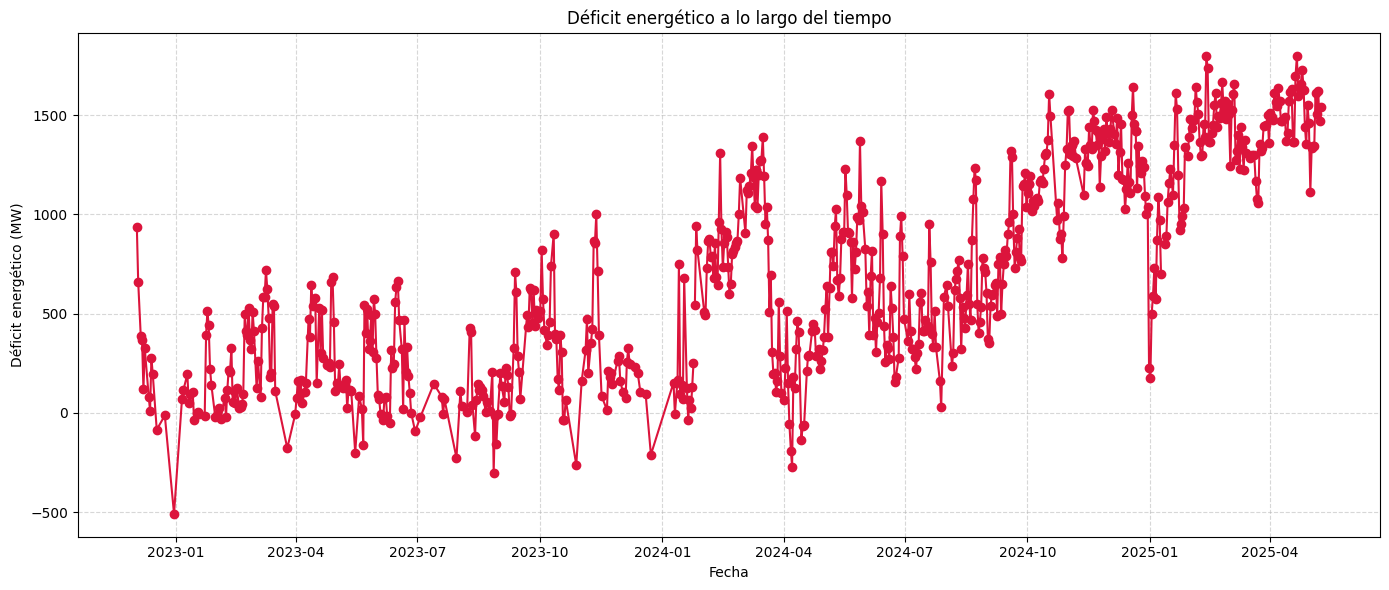

In [24]:
# Ordenar por fecha (por si existe algun dia desordenado)
df = df.sort_values('fecha')

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(df['fecha'], df['deficit_real'], marker='o', linestyle='-', color='crimson')
plt.xlabel('Fecha')
plt.ylabel('Déficit energético (MW)')
plt.title('Déficit energético a lo largo del tiempo')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [25]:
features = ['demanda_maxima', 'demanda_07am','plantas_mantenimiento','año']
X = df[features]
y = df['deficit_real']

# Eliminar filas con valores nulos
X_clean = X.dropna()
y_clean = y[X_clean.index]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

## Random Forest

In [26]:
# Búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluación
y_pred_rf = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred_rf)
medae = median_absolute_error(y_test, y_pred_rf)

print('Mejores hiperparámetros:', grid_search.best_params_)
print('MSE:', mse)
print('R²:', r2)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', f'{mape:.2%}')
print('MedAE:', medae)

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
MSE: 34499.838087445285
R²: 0.8801746792619465
MAE: 147.77218592318835
RMSE: 185.74132035560984
MAPE: 932078202322569344.00%
MedAE: 123.43153712108193


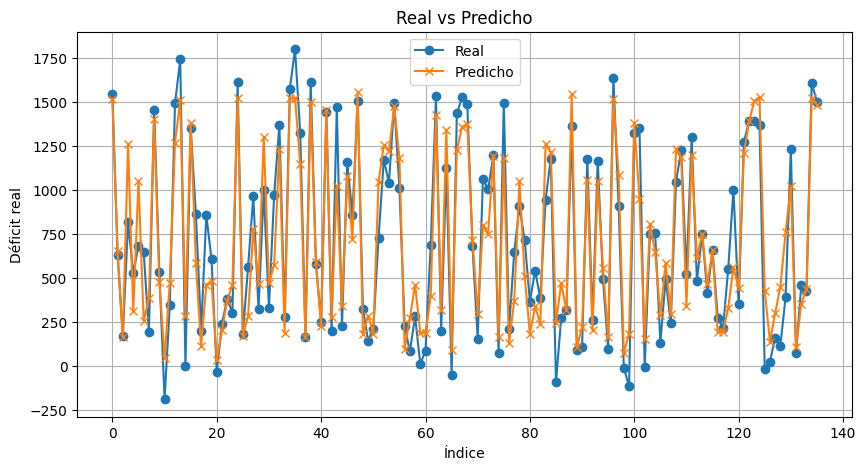

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Real', marker='o')
plt.plot(y_pred_rf, label='Predicho', marker='x')
plt.title('Real vs Predicho')
plt.xlabel('Índice')
plt.ylabel('Déficit real')
plt.legend()
plt.grid(True)
plt.show()

## SVR

In [29]:
# 5. Escalado de features (muy importante para SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Búsqueda de hiperparámetros para SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# 7. Evaluación del mejor modelo
best_svr = grid_search.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)
mae = mean_absolute_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred_svr)
medae = median_absolute_error(y_test, y_pred_svr)

print('Mejores hiperparámetros:', grid_search.best_params_)
print('MSE:', mse)
print('R²:', r2)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', f'{mape:.2%}')
print('MedAE:', medae)

Mejores hiperparámetros: {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}
MSE: 36606.48163687183
R²: 0.8728578553872672
MAE: 156.57756134106162
RMSE: 191.32820397649644
MAPE: 986403922634150144.00%
MedAE: 146.900513042286


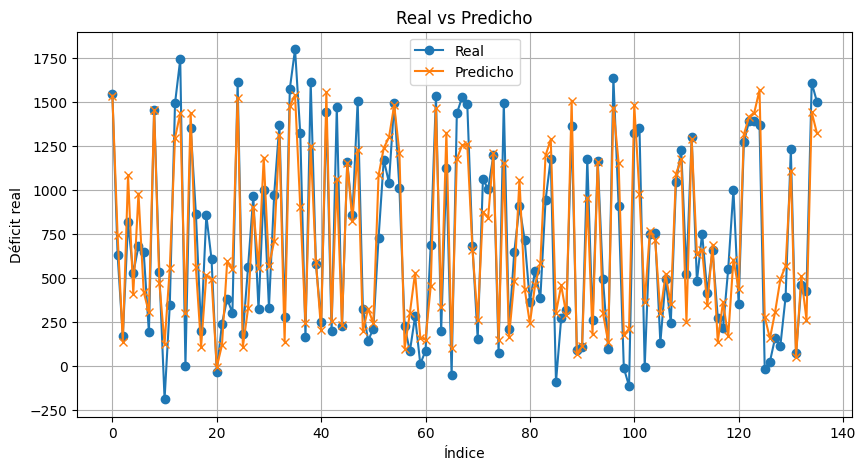

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Real', marker='o')
plt.plot(y_pred_svr, label='Predicho', marker='x')
plt.title('Real vs Predicho')
plt.xlabel('Índice')
plt.ylabel('Déficit real')
plt.legend()
plt.grid(True)
plt.show()

## Gradient Boosting Regressor

In [30]:

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_
y_pred_gb = best_gb.predict(X_test)


mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
mae = mean_absolute_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred_svr)
medae = median_absolute_error(y_test, y_pred_svr)

print('Mejores hiperparámetros:', grid_search.best_params_)
print('MSE:', mse)
print('R²:', r2)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', f'{mape:.2%}')
print('MedAE:', medae)

Mejores hiperparámetros: {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}
MSE: 36606.48163687183
R²: 0.8728578553872672
MAE: 156.57756134106162
RMSE: 191.32820397649644
MAPE: 986403922634150144.00%
MedAE: 146.900513042286


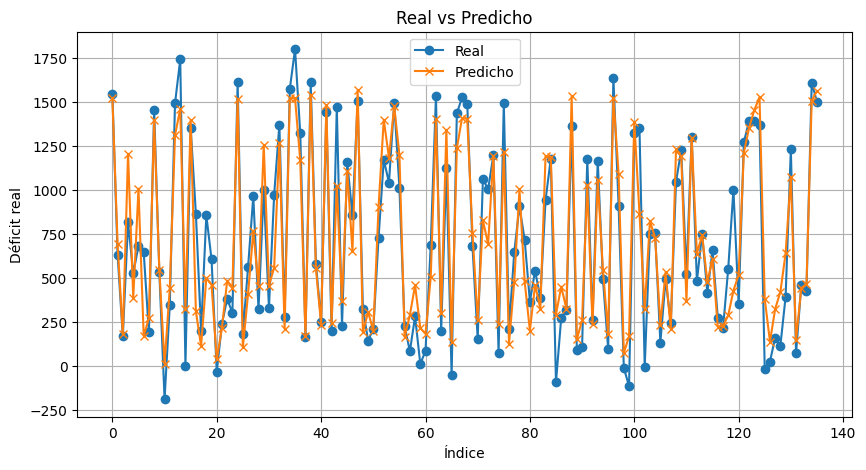

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Real', marker='o')
plt.plot(y_pred_gb, label='Predicho', marker='x')
plt.title('Real vs Predicho')
plt.xlabel('Índice')
plt.ylabel('Déficit real')
plt.legend()
plt.grid(True)
plt.show()